In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from glob import glob
import os.path
from collections import OrderedDict

%matplotlib inline

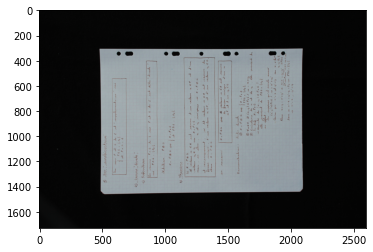

In [2]:
#img0 = cv2.imread('./_data/raw/canon 1/IMG_1052.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/categorized/simple/IMG_1086.JPG')
#rotation = 90

#img0 = cv2.imread('./_data/raw/canon 3/IMG_1156.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3284.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3051.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3645.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3647.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3636.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3637.JPG')
#rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3811.JPG')
#rotation = -90

img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3371.JPG')
rotation = -90

#img0 = cv2.imread('./_data/scanprepa/Math Sup/Math/IMG_3530.JPG')
#rotation = -90


plt.imshow(img0)

# Image rotation

CPU times: user 717 ms, sys: 3.64 ms, total: 721 ms
Wall time: 102 ms


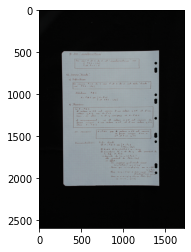

In [3]:
def rotateAboutCenter(src, angle, scale=1.):
    """Rotate an image by a given angle."""
    w = src.shape[1]
    h = src.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle)*h) + abs(np.cos(rangle)*w))*scale
    nh = (abs(np.cos(rangle)*h) + abs(np.sin(rangle)*w))*scale
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw*0.5, nh*0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw-w)*0.5, (nh-h)*0.5,0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0,2] += rot_move[0]
    rot_mat[1,2] += rot_move[1]
    return cv2.warpAffine(src, rot_mat,
                          (int(math.ceil(nw)), int(math.ceil(nh))),
                         flags=cv2.INTER_LANCZOS4)

%time img1 = rotateAboutCenter(img0, rotation)

plt.imshow(img1)

# Contour detection.

## Extract contours

In [4]:
# Some useful functions

def printContoursDetails(contours):
    """Prints the details of a contour."""
    print("{} contours:".format(len(contours)))
    for i, c in enumerate(contours):
        print(" -{} ({} points): {}".format(i, len(c), str(c).replace('\n', '')))
        
def points2Contour(points):
    """Returns a 'contour' based on a list of 2-uplets."""
    return np.array([[[p[0], p[1]]] for p in points], dtype='int32')

def contour2Points(contour):
    """Returns a list of 2-uplets based on a contour."""
    return [(point[0][0], point[0][1]) for point in contour]

def contour2Segments(contour):
    """Returns a list of segments, defined by two points based on a contour."""
    points = contour2Points(contour)
    nextpoints = points[1:] + points[:1]
    return list(zip(points, nextpoints))

def segments2Contour(segments):
    """Returns a 'contour' based on a list of segments."""
    points = [s[0] for s in segments]
    return points2Contour(points)
    
def intersection_lines(a1,a2,b1,b2):
    """Returns the intersection of two lines, each defined by 2 points."""
    x1, y1 = a1
    x2, y2 = a2
    x3, y3 = b1
    x4, y4 = b2
    den = 1.0*(y4-y3)*(x2-x1)-(x4-x3)*(y2-y1)
    if den == 0:
        return None
    num = 1.0*(x4-x3)*(y1-y3)-(y4-y3)*(x1-x3)
    ua = num / den
    return int(x1+ua*(x2-x1)), int(y1+ua*(y2-y1))

def angle(seg1, seg2):
    """Return the angle defined by two segments."""
    x1 = seg1[1][0]-seg1[0][0]
    y1 = seg1[1][1]-seg1[0][1]
    x2 = seg2[1][0]-seg2[0][0]
    y2 = seg2[1][1]-seg2[0][1]
    normdot = (1.0*x1*x2+y1*y2) / (math.sqrt(x1**2+y1**2)*math.sqrt(x2**2+y2**2))
    return math.degrees(math.acos(normdot))

3 contours:
 -0 (5 points): [[[ 679 2085]] [[ 680 2085]] [[ 681 2086]] [[ 682 2086]] [[ 682 2085]]]
 -1 (1 points): [[[274 506]]]
 -2 (302 points): [[[1416  480]] [[1415  481]] [[1395  481]] [[1394  482]] [[1373  482]] [[1372  483]] [[1353  483]] [[1352  484]] [[1332  484]] [[1331  485]] [[1306  485]] [[1305  486]] [[1274  486]] [[1273  487]] [[1223  487]] [[1222  488]] [[1152  488]] [[1151  489]] [[1073  489]] [[1072  490]] [[ 999  490]] [[ 998  491]] [[ 997  490]] [[ 996  491]] [[ 995  491]] [[ 994  490]] [[ 993  491]] [[ 908  491]] [[ 907  492]] [[ 584  492]] [[ 583  491]] [[ 582  492]] [[ 579  492]] [[ 578  491]] [[ 454  491]] [[ 453  490]] [[ 450  490]] [[ 449  491]] [[ 448  490]] [[ 324  490]] [[ 323  489]] [[ 322  490]] [[ 319  490]] [[ 318  489]] [[ 317  489]] [[ 316  490]] [[ 315  490]] [[ 314  489]] [[ 313  489]] [[ 312  490]] [[ 295  490]] [[ 294  491]] [[ 293  491]] [[ 292  492]] [[ 291  492]] [[ 288  495]] [[ 288  496]] [[ 284  500]] [[ 284  501]] [[ 282  503]] [[ 281  503

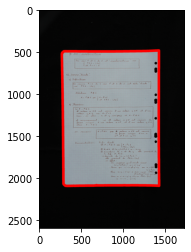

In [5]:
# Find all the contours in the page

def findContours(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = findContours(img1)

# Display
printContoursDetails(contours)
img11 = img1.copy()
cv2.drawContours(img11, contours, -1, (255,0,0), 30)
plt.imshow(img11)


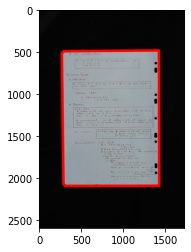

In [6]:

def convexHulls(contours):
    return [cv2.convexHull(contour) for contour in contours]

contours = convexHulls(contours)

img111 = img1.copy()
cv2.drawContours(img111, contours, -1, (255,0,0), 30)
plt.imshow(img111)


## Filter contours

In [7]:
# 5 points are needed to complete a rectangle

def filterBasedOnLength(contours):
    return [cnt for cnt in contours if len(cnt) > 4]

contours = filterBasedOnLength(contours)

# Display
printContoursDetails(contours)

1 contours:
 -0 (21 points): [[[1423 2084]] [[1422 2089]] [[ 375 2091]] [[ 329 2091]] [[ 314 2090]] [[ 311 2089]] [[ 299 2079]] [[ 293 2073]] [[ 290 2069]] [[ 289 2066]] [[ 288 2018]] [[ 270  567]] [[ 270  519]] [[ 271  516]] [[ 276  505]] [[ 291  492]] [[ 295  490]] [[ 313  489]] [[1416  480]] [[1418  480]] [[1420  481]]]


1 contours:
 -0 (21 points): [[[1423 2084]] [[1422 2089]] [[ 375 2091]] [[ 329 2091]] [[ 314 2090]] [[ 311 2089]] [[ 299 2079]] [[ 293 2073]] [[ 290 2069]] [[ 289 2066]] [[ 288 2018]] [[ 270  567]] [[ 270  519]] [[ 271  516]] [[ 276  505]] [[ 291  492]] [[ 295  490]] [[ 313  489]] [[1416  480]] [[1418  480]] [[1420  481]]]


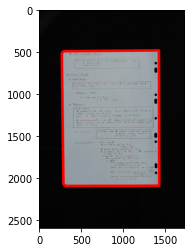

In [8]:
# Select the contour with the biggest area

def selectContourBasedOnArea(contours):
    contours.sort(key=lambda c:cv2.contourArea(c))
    return contours[-1]

contour = selectContourBasedOnArea(contours)

# Display
printContoursDetails([contour])
img12 = img1.copy()
cv2.drawContours(img12, [contour], -1, (255,0,0), 30)
plt.imshow(img12)

## Rework the contour to find the 4 angles of the sheet

1 contours:
 -0 (9 points): [[[1422 2089]] [[ 329 2091]] [[ 311 2089]] [[ 290 2069]] [[ 270  519]] [[ 276  505]] [[ 291  492]] [[ 313  489]] [[1420  481]]]


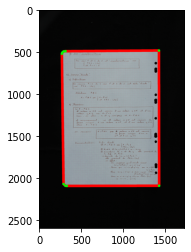

In [9]:
# Approximate the contours

# The value of alpha should be "right" to have a contour with
# at least 4 segments "representative" of the edges of the
# sheet of paper.
# "Representative" could be at least a 1/4 of the image smallest
# dimension.
# Good value of alpha: 0.0005
alpha = 0.0005

def approximateContour(contour, alpha):
    return cv2.approxPolyDP(contour, alpha*cv2.arcLength(contour, True), True)

contour = approximateContour(contour, alpha)

# Display
printContoursDetails([contour])    
img13 = img1.copy()
cv2.drawContours(img13, [contour], -1, (255,0,0), 30)
cv2.drawContours(img13, contour, -1, (0,255,0), 30)
plt.imshow(img13)


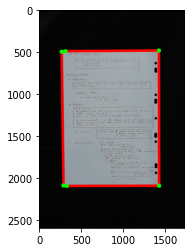

In [11]:
# Remove segments that form broken angles

# Angle above which an angle is not considered a straigh line
# or a 90 degrees angle (90-theta in this last case).
theta = 10

# Ratio of the length of a page below which a segment cannot
# be a broken angle
gamma = .2

def removeBrokenAngles(contour, theta, gamma, img):

    maxBrokenAngleLength = gamma * min(img.shape[:2])
    
    # Retrieve all segments that participate to angles different than 0 or 90 degrees.
    segments = contour2Segments(contour)
    toremove = []
    previous_current_next = list(zip(range(len(segments)),
                                     segments[-1:]+segments[:-1],
                                     segments,
                                     segments[1:]+segments[:1]))    
    for i, prevseg, seg, nextseg in previous_current_next:
        prevangle = abs(angle(prevseg, seg))
        nextangle = abs(angle(seg, nextseg))
        length = math.sqrt((seg[1][0]-seg[0][0])**2+(seg[1][1]-seg[0][1])**2)
        if ((theta < prevangle < 90-theta) and
            (theta < nextangle < 90-theta) and
            (length < maxBrokenAngleLength)):
            toremove.append(i)
    
    # Remove/update segments
    i = 0
    removed = 0
    length = len(segments)
    while i < length:
        iminus, iplus = (i-1)%length, (i+1)%length 
        if i+removed in toremove:
            # Compute intersection of previous & next segments
            (a1, a2) = segments[iminus]
            (b1, b2) = segments[iplus]
            (x, y) = intersection_lines(a1,a2,b1,b2)
            # Update previous & next segments
            segments[iminus] = (segments[iminus][0], (x, y))
            segments[iplus] = ((x, y), segments[iplus][1])
            # Remove current segment
            segments = segments[:i]+segments[i+1:]
            removed += 1
            length -= 1
        else:
            i += 1
        
    return segments2Contour(segments)
 
contour = removeBrokenAngles(contour, theta, gamma, img1)

# Display
img15 = img1.copy()
cv2.drawContours(img15, [contour], -1, (255,0,0), 30)
cv2.drawContours(img15, contour, -1, (0,255,0), 50)
plt.imshow(img15)


1 contours:
 -0 (4 points): [[[ 268  495]] [[ 290 2086]] [[1422 2089]] [[1420  481]]]


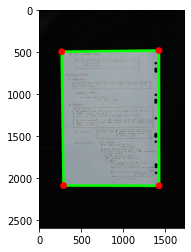

In [12]:
def findCorners(contour):
    v1 = [i[0][0]+i[0][1] for i in contour]
    topleft = v1.index(min(v1))
    bottomright = v1.index(max(v1))
    v2 = [i[0][0]-i[0][1] for i in contour]
    bottomleft = v2.index(min(v2))
    topright = v2.index(max(v2))
    ordered_indexes = [topleft, bottomleft, bottomright, topright]
    ordered_contour = np.array([contour[i] for i in ordered_indexes])
    return ordered_contour

contour = findCorners(contour)

#Display
printContoursDetails([contour])
imgt = img1.copy()
cv2.drawContours(imgt, [contour], -1, (0,255,0), 30)
cv2.drawContours(imgt, contour, -1, (255,0,0), 80)
plt.imshow(imgt)

# Determine 'A4' zone

In [13]:
def computeA4subarea(img):
    """Return the dimension (rows, cols) of the biggest subarea
    of the image that would have the same proportion than an
    A4 page."""
    rows, cols, ch = img.shape
    rowsA4, colsA4 = 297, 210
    newrows, newcols = rows, cols
    if 1.0*rows/cols > rowsA4/colsA4:
        newrows = int(1.0 * cols * rowsA4 / colsA4)
    else:
        newcols = int(1.0 * rows * colsA4 / rowsA4)
    return newrows, newcols

newrows, newcols = computeA4subarea(img1)

# Display
rows, cols, ch = img1.shape
print("image dimension:    ", rows, cols)
print("proposed dimension: ", newrows, newcols)


image dimension:     2592 1729
proposed dimension:  2445 1729


# Changement of perspective

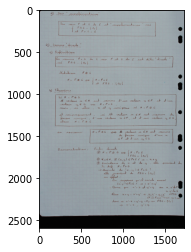

In [14]:

def reframePage(contour, img, rows, cols):
    # The points that will define the transformation
    pts_origin = np.float32(contour)
    pts_destination = np.float32([[0,0],
                                  [0,rows],
                                  [cols,rows],
                                  [cols,0]])
    # Apply the transformation
    imgrows, imgcols, _ = img1.shape
    M = cv2.getPerspectiveTransform(pts_origin, pts_destination)
    newimg = cv2.warpPerspective(img, M, (imgcols,imgrows))
    return newimg
    
img2 = reframePage(contour, img1, newrows, newcols)    
    
#cv2.imwrite("out2.jpg", img2)
plt.imshow(img2)

# Crop the image

(2445, 1729, 3)


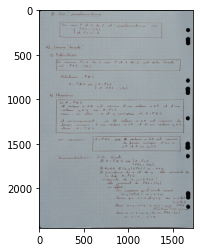

In [15]:

def cropImage(img, rows, cols):
    return img[0:rows, 0:cols]
    
img3 = cropImage(img2, newrows, newcols)

# Display
print(img3.shape)
plt.imshow(img3)

# Batch processing

In [16]:
def detectPage(img, alpha=0.0005, theta=10, gamma=0.2):
    contours = findContours(img)
    contours = convexHulls(contours)
    contours = filterBasedOnLength(contours)
    contour = selectContourBasedOnArea(contours)
    contour = approximateContour(contour, alpha)
    contour = removeBrokenAngles(contour, theta, gamma, img)
    contour = findCorners(contour)
    return contour

def reframeImage(img, contour):
    rows, cols = computeA4subarea(img)
    img = reframePage(contour, img, rows, cols)
    img = cropImage(img, rows, cols)
    return img

In [17]:
rm ./_out/*

In [ ]:
imgpaths = glob('./_data/scanprepa/Math Sup/Math/*')
imgpaths.sort()
imgpaths = [imgpath for imgpath in imgpaths if imgpath[-4:].lower() == ".jpg"]

rotation = -90

imagesDict = OrderedDict()
    
for imgpath in imgpaths:

    basename = os.path.basename(imgpath)
    print(basename)

    img = cv2.imread(imgpath)
    img = rotateAboutCenter(img, rotation)
    contour = detectPage(img)
    newimg = reframeImage(img, contour)

    imagesDict[basename] = {"contour": str(contour2Points(contour)),
                            "rotation": rotation}
             
    outfile = os.path.join('./_out/', basename)
    cv2.imwrite(outfile, newimg)

    

In [18]:
# Save data

with open('./_out/data.txt', 'w') as out:
    print(str(imagesDict), file=out) 
    

IMG_3051.JPG
IMG_3052.JPG
IMG_3053.JPG
IMG_3054.JPG
IMG_3055.JPG
IMG_3056.JPG
IMG_3057.JPG
IMG_3058.JPG
IMG_3059.JPG
IMG_3060.JPG
IMG_3061.JPG
IMG_3062.JPG
IMG_3063.JPG
IMG_3064.JPG
IMG_3065.JPG
IMG_3066.JPG
IMG_3067.JPG
IMG_3068.JPG
IMG_3069.JPG
IMG_3070.JPG
IMG_3071.JPG
IMG_3072.JPG
IMG_3073.JPG
IMG_3074.JPG
IMG_3075.JPG
IMG_3076.JPG
IMG_3077.JPG
IMG_3078.JPG
IMG_3079.JPG
IMG_3080.JPG
IMG_3081.JPG
IMG_3082.JPG
IMG_3083.JPG
IMG_3084.JPG
IMG_3085.JPG
IMG_3086.JPG
IMG_3087.JPG
IMG_3088.JPG
IMG_3089.JPG
IMG_3090.JPG
IMG_3091.JPG
IMG_3092.JPG
IMG_3093.JPG
IMG_3094.JPG
IMG_3095.JPG
IMG_3096.JPG
IMG_3097.JPG
IMG_3098.JPG
IMG_3099.JPG
IMG_3100.JPG
IMG_3101.JPG
IMG_3102.JPG
IMG_3103.JPG
IMG_3104.JPG
IMG_3105.JPG
IMG_3106.JPG
IMG_3107.JPG
IMG_3108.JPG
IMG_3109.JPG
IMG_3110.JPG
IMG_3111.JPG
IMG_3112.JPG
IMG_3113.JPG
IMG_3114.JPG
IMG_3115.JPG
IMG_3116.JPG
IMG_3117.JPG
IMG_3118.JPG
IMG_3119.JPG
IMG_3120.JPG
IMG_3121.JPG
IMG_3122.JPG
IMG_3123.JPG
IMG_3124.JPG
IMG_3125.JPG
IMG_3126.JPG
IMG_3127.JPG

IMG_3682.JPG
IMG_3683.JPG
IMG_3684.JPG
IMG_3685.JPG
IMG_3686.JPG
IMG_3687.JPG
IMG_3688.JPG
IMG_3689.JPG
IMG_3690.JPG
IMG_3691.JPG
IMG_3692.JPG
IMG_3693.JPG
IMG_3694.JPG
IMG_3695.JPG
IMG_3696.JPG
IMG_3697.JPG
IMG_3698.JPG
IMG_3699.JPG
IMG_3700.JPG
IMG_3701.JPG
IMG_3702.JPG
IMG_3703.JPG
IMG_3704.JPG
IMG_3705.JPG
IMG_3706.JPG
IMG_3707.JPG
IMG_3708.JPG
IMG_3709.JPG
IMG_3710.JPG
IMG_3711.JPG
IMG_3712.JPG
IMG_3713.JPG
IMG_3714.JPG
IMG_3715.JPG
IMG_3716.JPG
IMG_3717.JPG
IMG_3718.JPG
IMG_3719.JPG
IMG_3720.JPG
IMG_3721.JPG
IMG_3722.JPG
IMG_3723.JPG
IMG_3724.JPG
IMG_3725.JPG
IMG_3726.JPG
IMG_3727.JPG
IMG_3728.JPG
IMG_3729.JPG
IMG_3730.JPG
IMG_3731.JPG
IMG_3732.JPG
IMG_3733.JPG
IMG_3734.JPG
IMG_3735.JPG
IMG_3736.JPG
IMG_3737.JPG
IMG_3738.JPG
IMG_3739.JPG
IMG_3740.JPG
IMG_3741.JPG
IMG_3742.JPG
IMG_3743.JPG
IMG_3744.JPG
IMG_3745.JPG
IMG_3746.JPG
IMG_3747.JPG
IMG_3748.JPG
IMG_3749.JPG
IMG_3750.JPG
IMG_3751.JPG
IMG_3752.JPG
IMG_3753.JPG
IMG_3754.JPG
IMG_3755.JPG
IMG_3756.JPG
IMG_3757.JPG
IMG_3758.JPG

In [23]:
# Read data

with open("./_out/data.txt", "r") as data:
    t = data.read()
    x = eval(t)
    print(x['IMG_3896.JPG'])

{'contour': '[(320, 422), (328, 2016), (1459, 2021), (1470, 426)]', 'rotation': -90}
